# Проект 'Прогностическая модель рисков беременных'

### Описание проекта

###### Задача: создать прогностическую модель рисков беременных.
###### Метрика: f_beta score со значением beta = 2, "макро" взвешиванием.  
###### Особенности: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.

###### Описание:  
__Age:__ _Age in years when a woman is pregnant._  

__SystolicBP:__  _Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy._  

__DiastolicBP:__  _Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy._  

__BS:__  _Blood glucose levels is in terms of a molar concentration, mmol/L._  

__HeartRate:__  _A normal resting heart rate in beats per minute._  

__Risk Level:__  _Predicted Risk Intensity Level during pregnancy considering the previous attribute._  

###### План исследования:   
1. Знакомство с датасетом  
    - Обзор
    - Корреляционный анализ
    - Попарное сравнение признаков
    - Визуализация признаков
2. Обработка
    - Генерация признаков: в соответствии с медицинскими номами для беременных и прочих
    - Подготовка данных к моделированию
3. Моделирование  
    - Перебор с помощью GridSearchCV моделей разных классов   
        + LogisticRegression, 
        + RandomForestClassifier, 
        + SVC, 
        + AdaBoostingClassifier на основе дерева решений.   
        и выбор лучших гиперпараметров для каждой модели
    - Применение техники стэкинга результатов этих моделей (финализирующий алгоритм - CatBoostClassifier).
    - Предсказание
4. Общий вывод

### Настройки

In [1]:
# Импорты
import warnings
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from catboost import CatBoostClassifier

In [2]:
# Настройки
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Константы
RS = 888
FBETA = make_scorer(fbeta_score, beta=2, 
         average='macro', 
         greater_is_better=True)

In [3]:
# Функции
def get_info(data):
    ''' 
    Возвращает основную информацию о датасете
    '''
    print(f'Основные показатели датасета:')
    print('-'*40)
    print(f'Количество признаков: {data.shape[1]}')
    print('-'*40)
    print(f'Количество сэмплов: {data.shape[0]}')
    print('-'*40,end='\n\n')
    print('Пример данных:')
    display(data.head(3))
    print('-'*40,end='\n\n')
    print('Описание данных:')
    display(data.describe().T)
    print('-'*40)
    data.info()
    print('-'*40)
    print(f'Процент пропусков в признаках:\n{round(data.isna().sum()/len(data)*100,2)}')
    print('-'*40)
    print(f'Количество дубликатов: {data.duplicated().sum()}')  
    
def searching(model, params, X_train, y_train):
    ''' 
    Строит пайплан, перебирает гиперпараметры, возвращает 
    обученную модель
    '''
    pipeline = Pipeline([
    ('transformer', column_transformer),
    ('model', model)
    ])
    
    search = RandomizedSearchCV(pipeline, 
                            param_distributions=params,
                            n_iter=10, 
                            n_jobs=-1, 
                            cv=5,
                            random_state=RS, 
                            scoring=FBETA)
    search.fit(X_train, y_train)
    return search

def validation_result(search):
    '''
    Возвращает результат на валидационной выборке
    '''
    return print(f'Лучший результат на валидационной выборке: {search.best_score_:.4f}')

def evaluation(y, y_hat):
    ''' 
    Возвращает значение метрики, матрицу ошибок
    '''
    print(f'f_beta = {fbeta_score(y, y_hat, beta=2, average="macro"):.4f}')

    ConfusionMatrixDisplay(confusion_matrix(y, 
                                        y_hat, 
                                        normalize='true'),
                           display_labels=target.unique()).plot();
          
def diabet_risk(x):
    '''
    Генерация категории диабета
    '''
    if x <= 5.0:
        return 'norm'
    elif 5.1 < x < 7.0:
        return 'gest_diabet'
    else:
        return 'sug_diabet'

def age_cat(x):
    ''' 
    Генерация категории возраста
    '''
    if x < 20:
        return '1'
    elif 20 <= x <= 35:
        return '2'
    elif 36 <= x <= 39:
        return '3'
    else: 
        return '4'
    
def temp_cat(x):
    '''
     Генерация категории температуры
    '''
    if x < 99.5:
        return 'ok'
    else: 
        return 'high'

In [4]:
os.getcwd()
os.chdir('../pregnacy')

# Знакомство с данными

### Обзор

In [5]:
# Загрузка датасета
data = pd.read_csv('datasets/Maternal Health Risk Data Set.csv')

# Получение основной информации о датасете
get_info(data)

Основные показатели датасета:
----------------------------------------
Количество признаков: 7
----------------------------------------
Количество сэмплов: 1014
----------------------------------------

Пример данных:


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk


----------------------------------------

Описание данных:


,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
----------------------------------------
Процент пропусков в признаках:
Age            0.0
SystolicBP     0.0
DiastolicBP    0.0
BS             0.0
BodyTemp       0.0
HeartRate      0.0
RiskLevel      0.0
dtype: float64
----------------------------------------
Количество дубликатов: 562


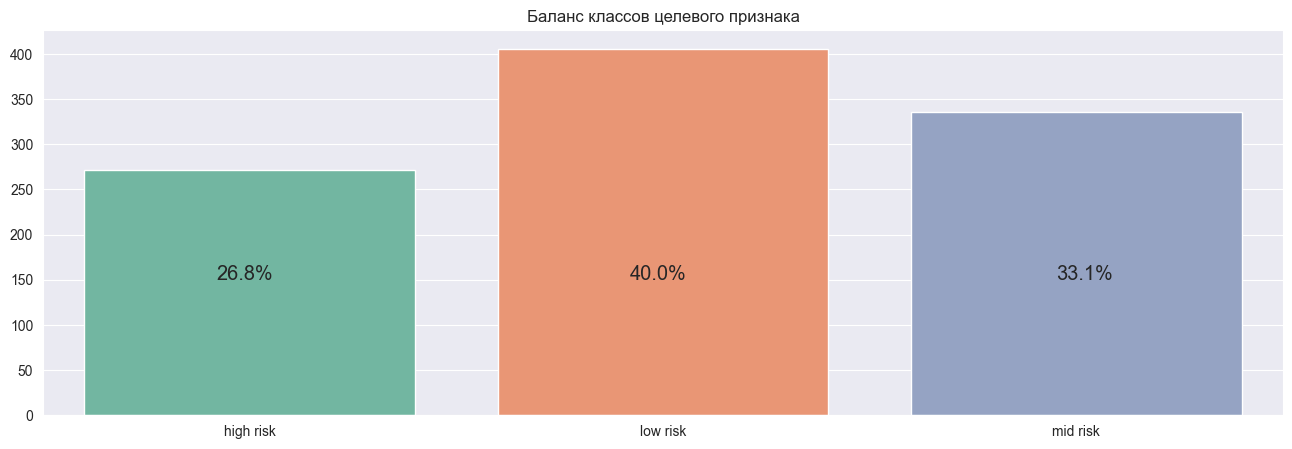

In [6]:
# Баланс классов
x = data['RiskLevel'].value_counts(normalize=True) * 100
plt.figure(figsize=(16,5))
sns.countplot(x=data['RiskLevel'], palette='Set2').set_title('Баланс классов целевого признака')
plt.text(0.92,150,f'{x[0]:.1f}%', fontsize='x-large')
plt.text(1.95,150,f'{x[1]:.1f}%', fontsize='x-large')
plt.text(-0.08,150,f'{x[2]:.1f}%', fontsize='x-large')
plt.xlabel('')
plt.ylabel('');

### Корреляционный анализ

interval columns not set, guessing: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']


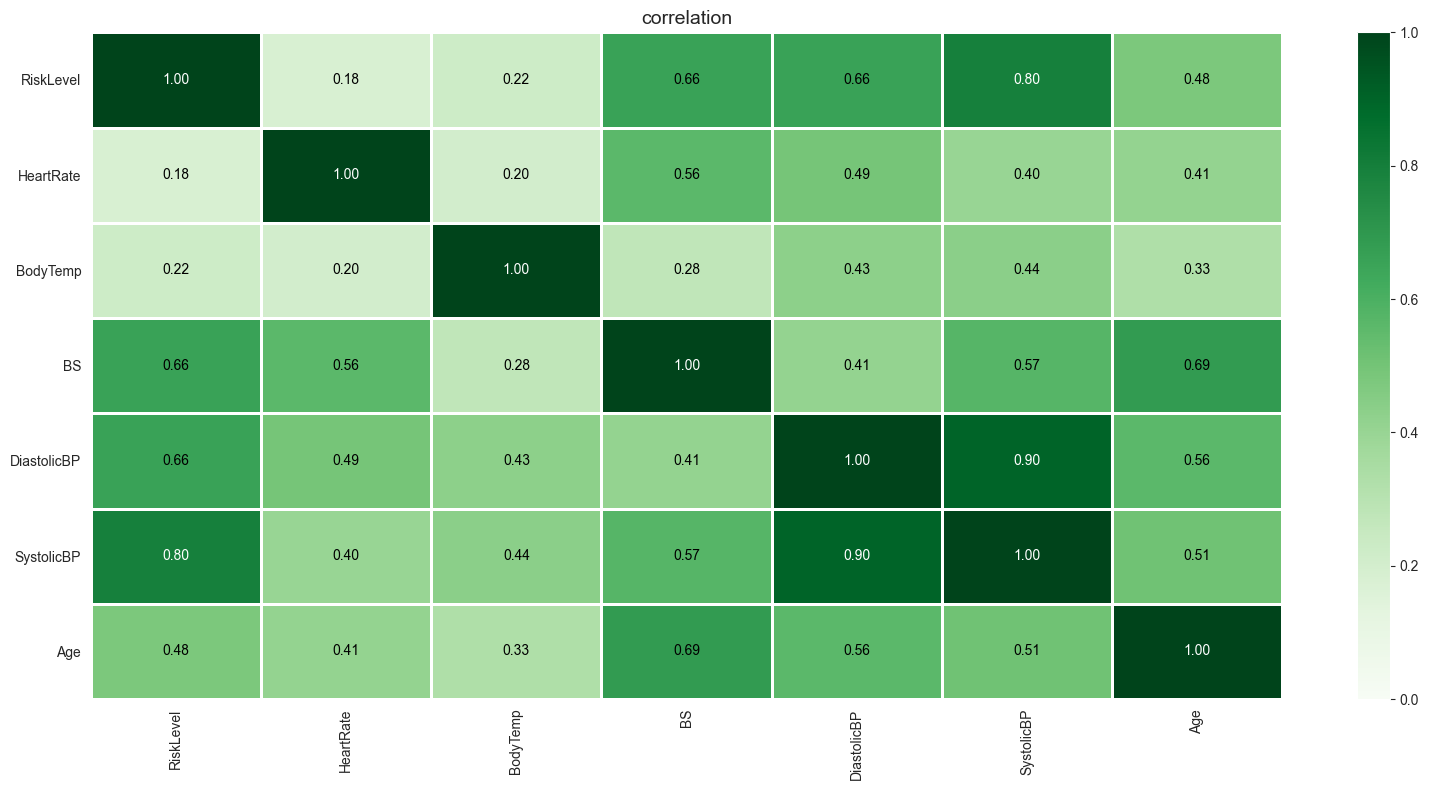

In [7]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        figsize=(16,8),
                        x_labels=phik_overview.index,
                        y_labels=phik_overview.columns,
                        vmin=0, vmax=1, color_map='Greens');

### Попарное сравнение признаков

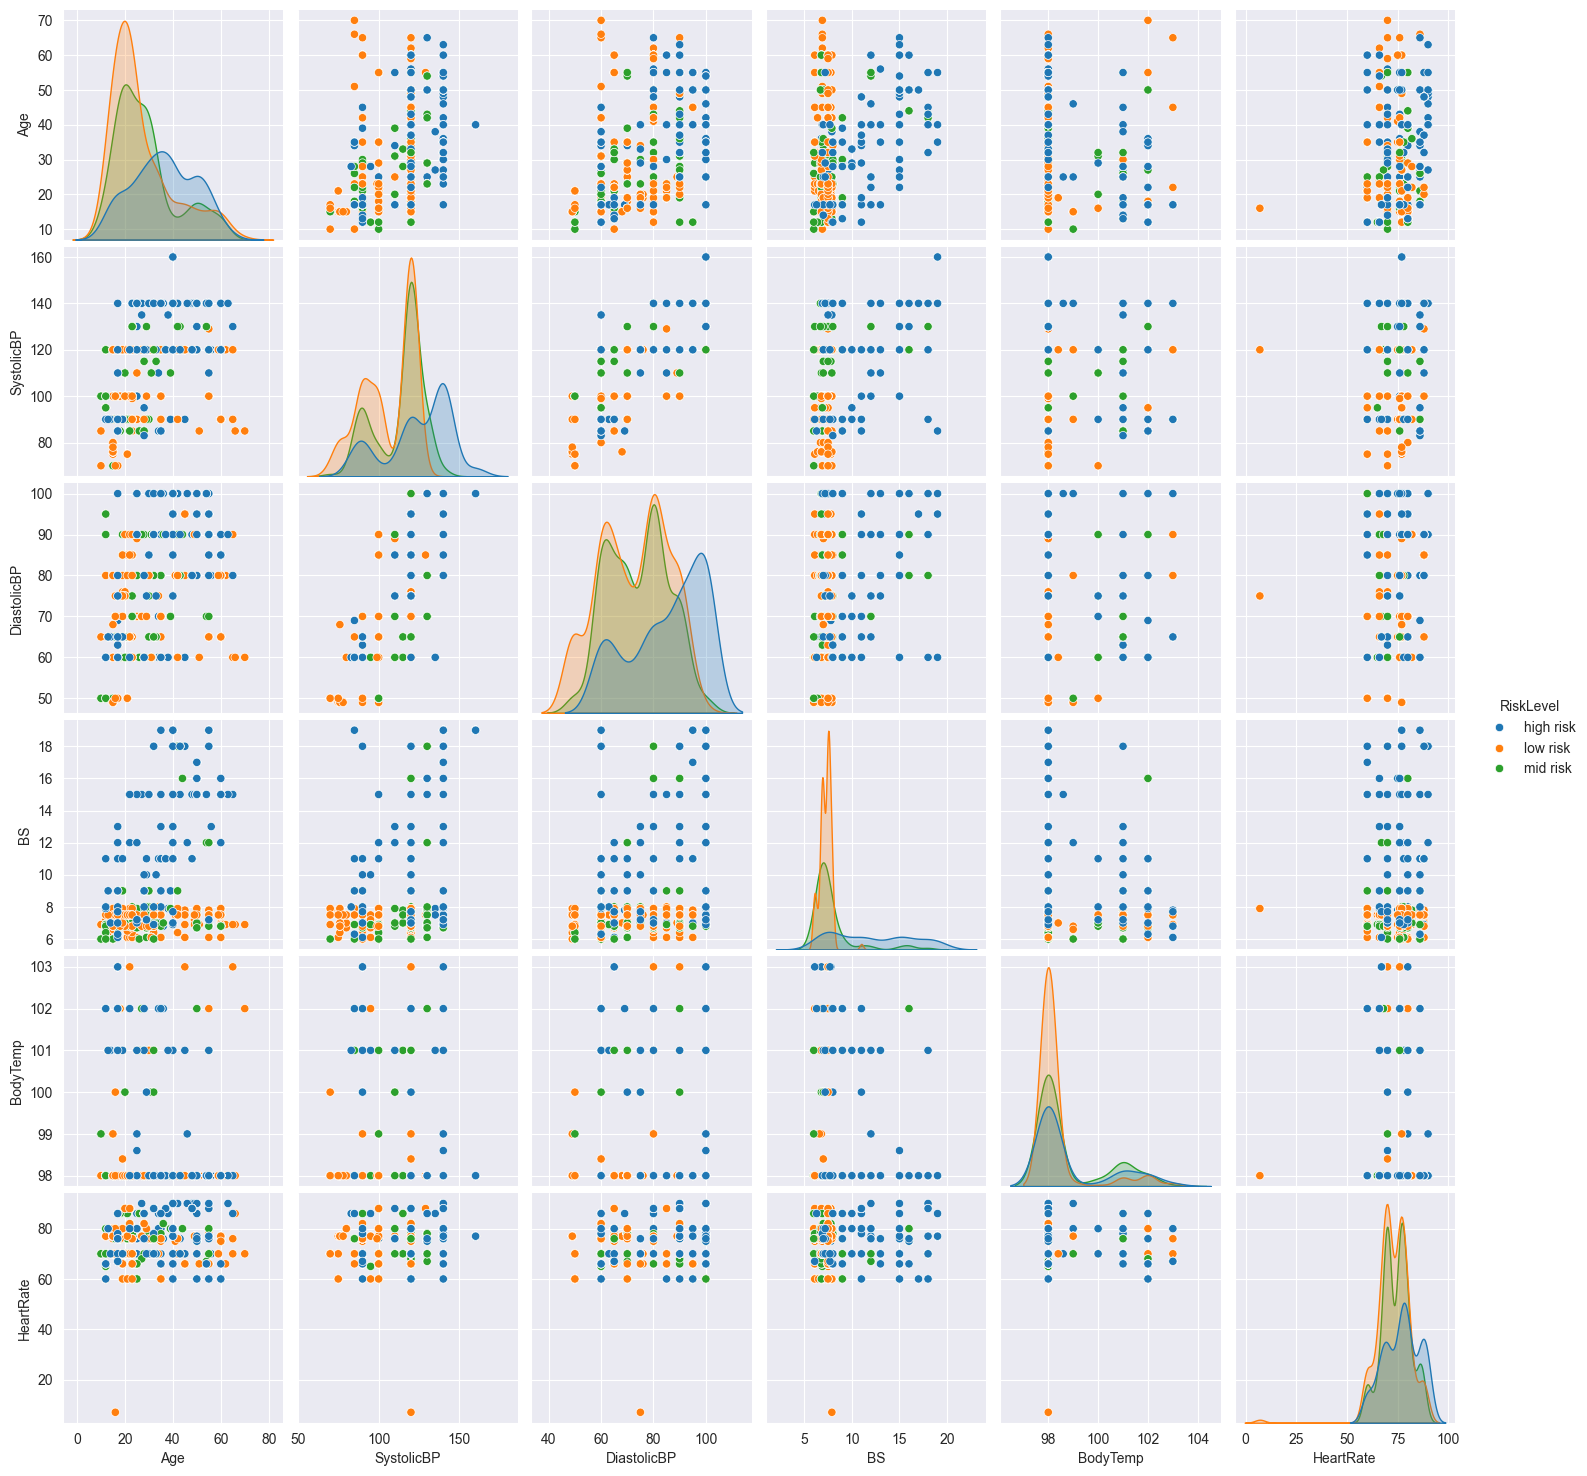

In [8]:
sns.pairplot(data, hue='RiskLevel');

### Визуализация признаков

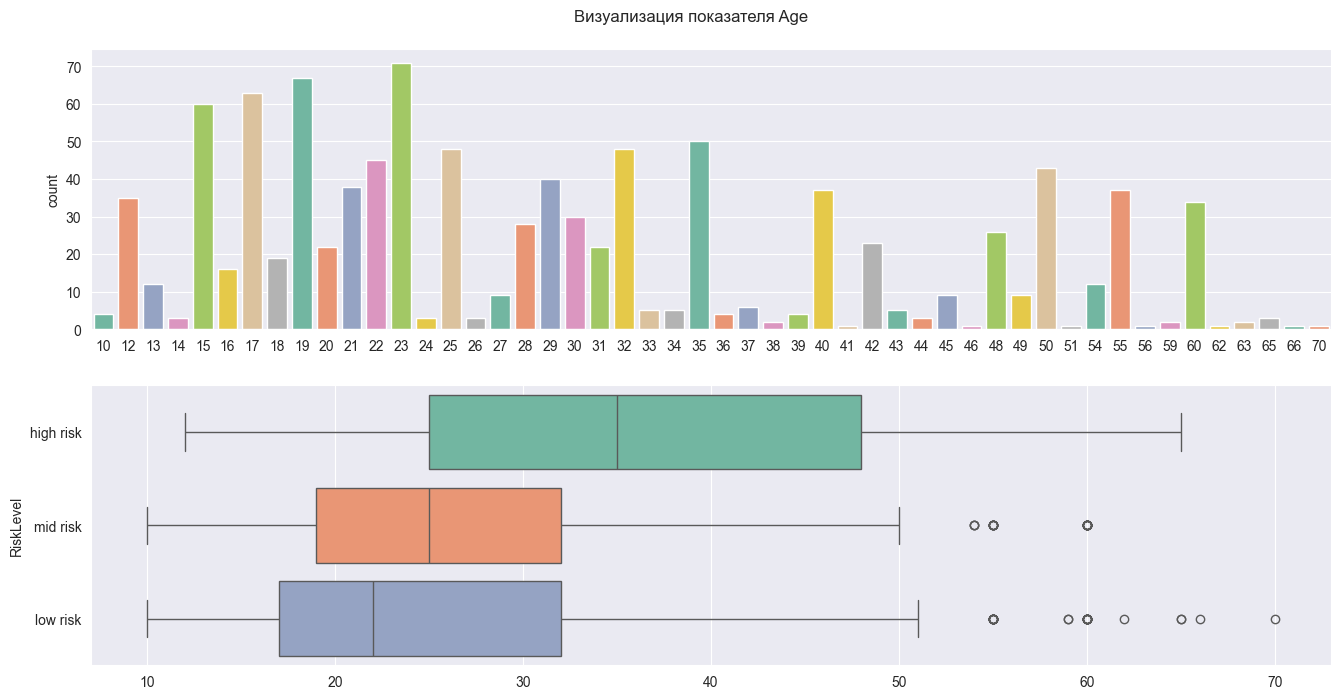

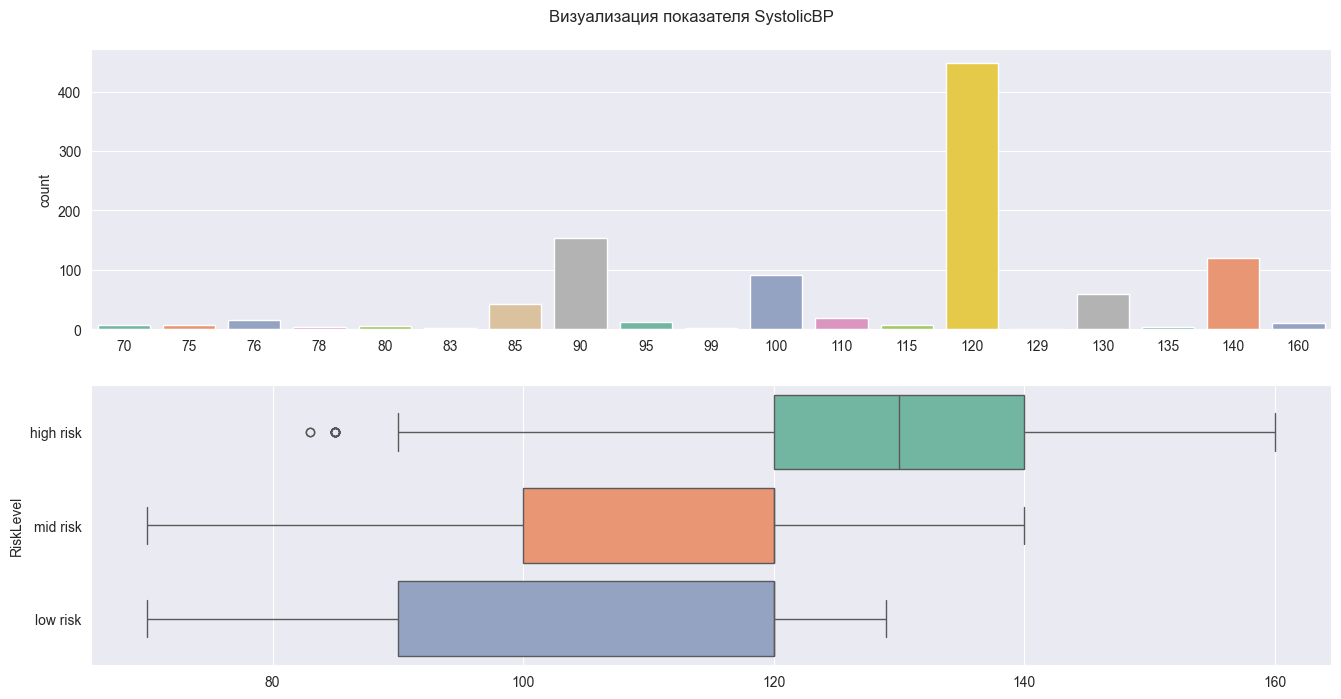

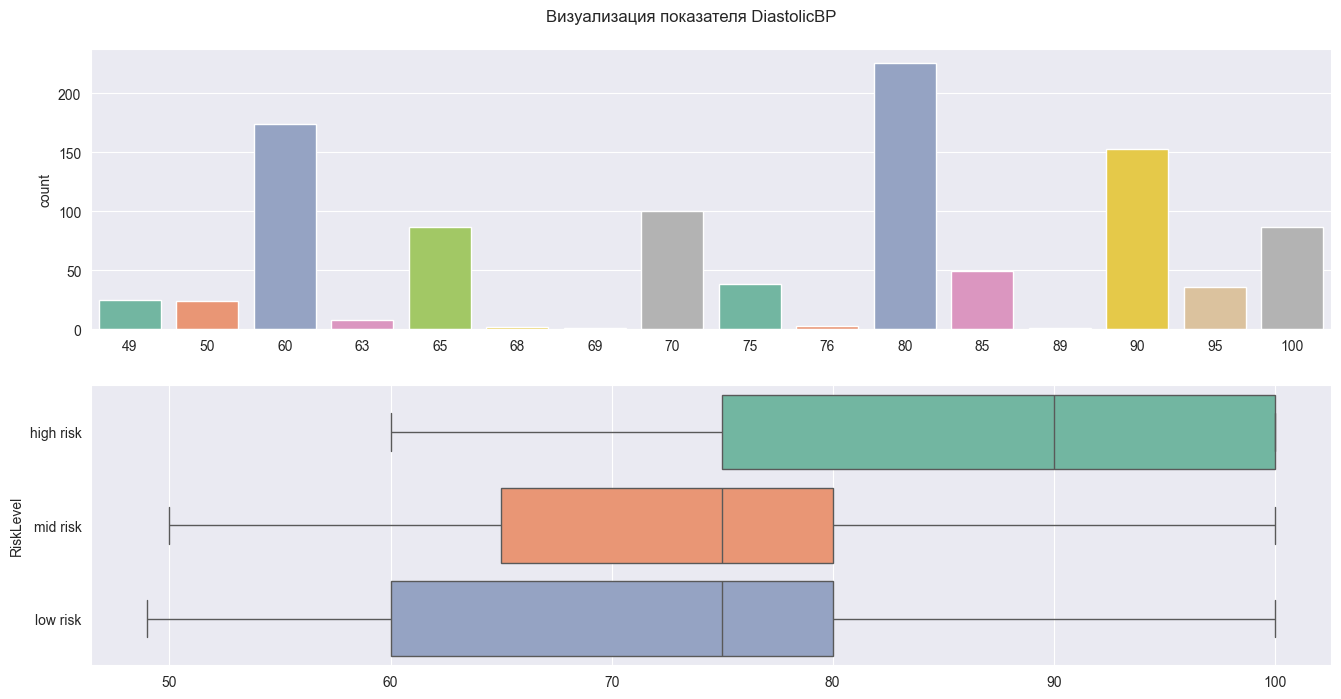

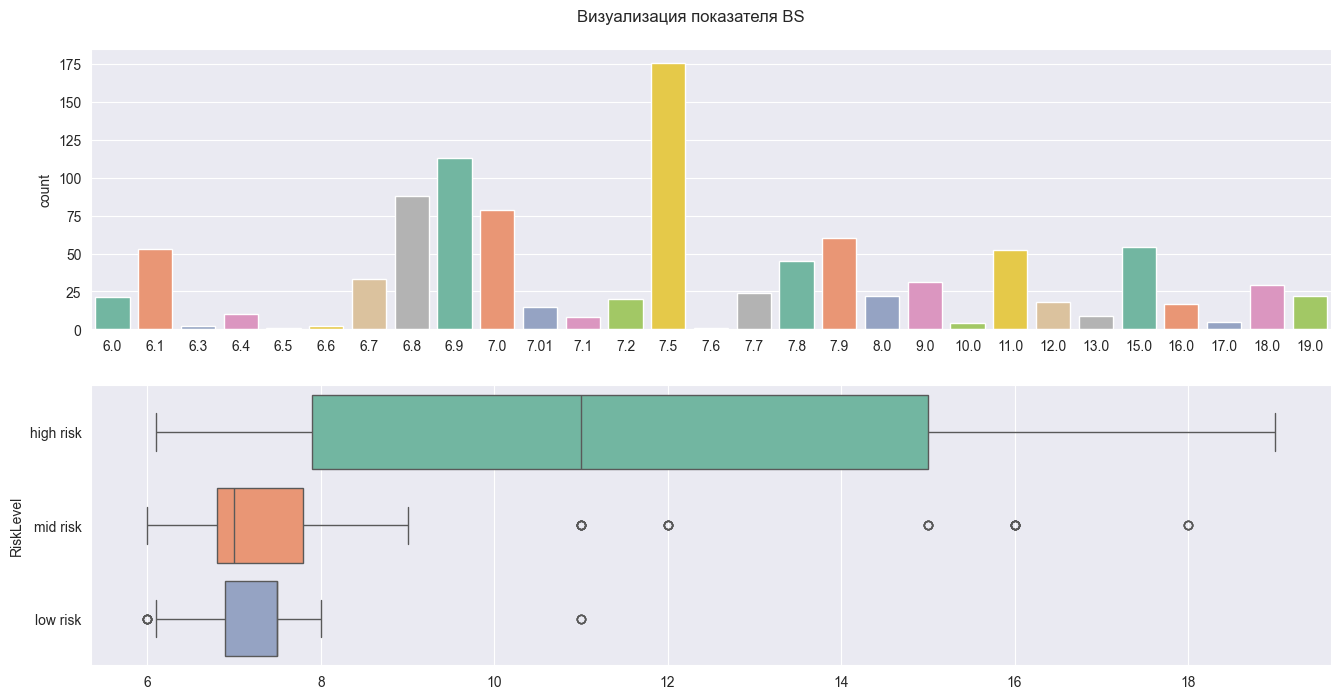

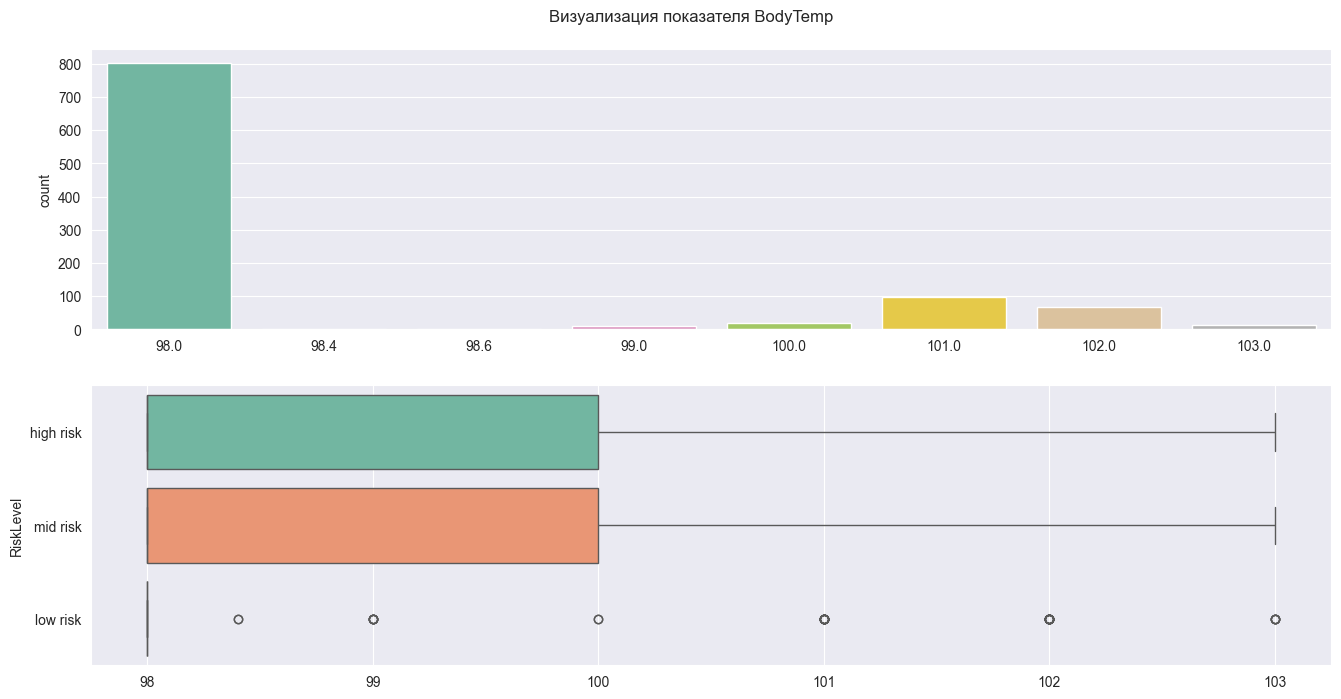

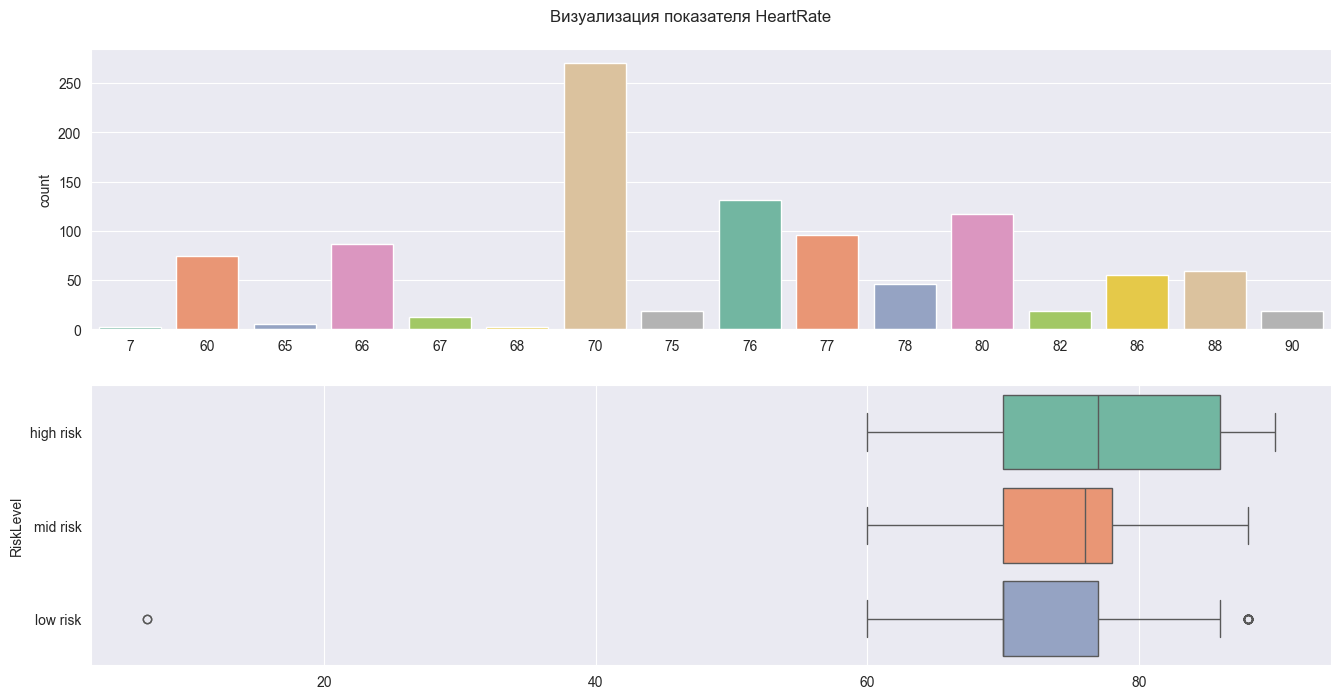

In [9]:
for feature in data.drop('RiskLevel', axis=1).columns:
    fig, ax = plt.subplots(2,1,figsize=(16,8))
    sns.countplot(x=data[feature], palette='Set2', ax=ax[0]).set_xlabel('')
    sns.boxplot(x=data[feature], y=data['RiskLevel'], palette='Set2', 
                order=['high risk','mid risk', 'low risk'], ax=ax[1]).set_xlabel('')
    plt.suptitle(f'Визуализация показателя {feature}', y=0.93);

### Вывод

1. Данные представлены 1014 записями и 7 признаками. Один из них целевой: RiskLevel.  
2. Целевой признак имеет дисбаланс классов low/mid/high  как 40/33/27.
3. Пропуски в данных отсутствуют, но есть 562 дубликата. 
4. Почти во всех признаках наблюдается незначительное расхождение среднего и медианы.  
5. Возраст варьируется от 10 до 70 лет.  
6. Верхнее и нижнее давление лежат в пределах шкалы измерения.
7. Содержание глюкозы в крови у всех пациенток выше нормы, но так же находится в пределах шкалы измерения. 
8. Температура выражена по шкале Фаренгейта. Единичные выбросы объяснимы с точки зрения медицины.
9. Показатель ЧСС лежит в пределах 7-90 уд./мин. Явно есть ошибочная запись, если пациент не земноводное.
10. Корреляционный анализ указывает на естественную связь нижнего и верхнего давления, а так же на сильную связь между верхним давлением и целевым признаком. 
11. Попарный анализ признаков:   
    - указывает на возможные округления некоторых показателей  
    - выявил выброс в показателе ЧСС 
    - указывает, что чем больше возраст или выше давление или содержание глюкозы в крови, тем больше вероятность попасть в группу высокого риска
    - в датасете присутствуют пациентки возрастов до 18 и 50+, причем это не выглядит аномалией
12. В ходе визуализации признаков выявлено, что при росте показателей категория риска возрастает.
---
В рамках данного исследования не понятно, является ли индекс уникальным id пациента. Основываясь на том, что разброс показателей признаков априори не может был значительным, а так же вероятность округления некоторых показателей при занесении в датасет, принмается допущение, что все номера индексов являются уникальными id пациента.

# Обработка

### Инжиниринг

In [10]:
# Уборка выброса
data = data.loc[data['HeartRate'] != 7]

In [11]:
# Генерация категории диабета
data['diabet_risk'] = data['BS'].apply(diabet_risk)

In [12]:
# Генерация категории возраста
data['age_cat'] = data['Age'].apply(age_cat)

In [13]:
# Генерация категории температуры
data['temp_cat'] =data['BodyTemp'].apply(temp_cat)

In [14]:
# Генерация признака разницы показателей верхнего и нижнего давления
data['BP_diff'] = data['SystolicBP'] - data['DiastolicBP']

In [15]:
# Генерация категории давления
data['BP_cat'] = 'optim'
data.loc[(data['SystolicBP'] < 90) | (data['DiastolicBP'] < 60), 'BP_cat'] = 'hypo'
data.loc[(data['SystolicBP'] >= 120) | (data['DiastolicBP'] >= 80),'BP_cat'] = 'norm'
data.loc[(data['SystolicBP'] >= 130) | (data['DiastolicBP'] >= 85),'BP_cat'] = 'high_norm'
data.loc[(data['SystolicBP'] >= 140) | (data['DiastolicBP'] >= 90),'BP_cat'] = 'hypo_1'
data.loc[(data['SystolicBP'] >= 160) | (data['DiastolicBP'] >= 100),'BP_cat'] = 'hypo_2'

In [16]:
# Генерация признака отношение ЧСС к содержанию глюкозы в крови
data['HR/BS'] = data['HeartRate'] / data['BS']

### Подготовка к моделированию

In [17]:
# Перевод категориальных признаков к типу category
for feature in data.select_dtypes(include='object').columns:
    data[feature] = data[feature].astype('category')

In [18]:
# Выделение целевого признака
target = data['RiskLevel']
features = data.drop(['RiskLevel'], axis=1)

# Разделение выборок
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                   test_size=0.25, 
                                                   random_state=RS,
                                                   stratify=target,
                                                   shuffle=True)

In [19]:
# Выделение номинативных и категориальных признаков
num_cols = features.select_dtypes(include=['int','float']).columns.to_list()
cat_cols = features.select_dtypes(include='category').columns.to_list()

# Инициализация трансформера номинативных переменных
quantile_transformer = QuantileTransformer(output_distribution='normal', 
                                           random_state=RS, 
                                           n_quantiles=X_train.shape[0])

# Инициализация энкодера категориальных переменных
oh_encoder = OneHotEncoder(sparse_output=False, 
                           handle_unknown='ignore', 
                           drop='first')

# Инициализация трансформера
column_transformer = ColumnTransformer([
    ('num_cols', quantile_transformer, num_cols),
    ('cat_cols', oh_encoder, cat_cols)
])

### Вывод

1. Удален выброс
2. В соответствии с медицинскими нормами для беременных сгенерированы признаки:   
    - категории диабета
    - категории возраста
    - категории давления
3. Дополнительно созданы признаки: 
    - категории температуры
    - разницы в верхнем и нижнем давлении
    - отношение ЧСС к содержанию глюкозы в крови
4. Категориальные признаки приведены к типу 'category'
5. Выделен целевой признак
6. Выборки разделены на тренировочную и тестовую
7. Для обработки номинативных и категориальных признаков: 
    - признаки разделены на две группы
    - инициализированы трансформеры

# Моделирование

### Обучение моделей

##### LogisticRegression


In [20]:
model = LogisticRegression(class_weight='balanced',
                           multi_class='multinomial',
                           random_state=RS,
                           n_jobs=-1)

model_params = {
    'model__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'model__C': [n for n in np.arange(0.01, 1.05, 0.01)],
    'model__max_iter': [n for n in np.arange(50, 1000, 50)]
    }

search = searching(model, 
                   model_params, 
                   X_train, 
                   y_train)

logreg = search.best_estimator_

validation_result(search)

Лучший результат на валидационной выборке: 0.6643


##### RandomForestClassifier

In [21]:
model = RandomForestClassifier(random_state=RS, 
                                class_weight='balanced', 
                                n_jobs=-1, 
                                bootstrap=False)
model_params = {
    'model__n_estimators': [n for n in np.arange(1,10001,4)],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [n for n in range(1,20,1)],
    'model__min_samples_split': [n for n in np.arange(2,10,1)],
    'model__min_samples_leaf': [n for n in np.arange(2,50,5)],
    'model__max_leaf_nodes': [n for n in np.arange(2,50,5)],
    'model__warm_start': [True, False]
}

search = searching(model, 
                   model_params, 
                   X_train, 
                   y_train)

forest = search.best_estimator_

validation_result(search)

Лучший результат на валидационной выборке: 0.7464


##### SVC

In [22]:
model = SVC(class_weight='balanced',
            random_state= RS)

model_params = {
    'model__kernel': ['poly', 'rbf', 'sigmoid'],
    'model__gamma': [n for n in np.arange(0.01, 1, 0.01)],
    'model__C': [n for n in np.arange(0.01, 1.01, 0.01)],
    'model__decision_function_shape': ['ovo', 'ovr']
}

search = searching(model, 
                   model_params, 
                   X_train, 
                   y_train)

svc = search.best_estimator_

validation_result(search)

Лучший результат на валидационной выборке: 0.7904


##### AdaBoostClassifier

In [23]:
model = AdaBoostClassifier(random_state=RS, 
                        estimator=None)

model_params = {
    'model__n_estimators': [n for n in np.arange(10,10000, 10)],
    'model__learning_rate': [n for n in np.arange(0.001, 1.01, 0.001)],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

search = searching(model, 
                   model_params, 
                   X_train, 
                   y_train)

ada = search.best_estimator_

validation_result(search)

Лучший результат на валидационной выборке: 0.7417


### Стэкинг

In [24]:
estimators = [
    ('logreg', logreg[1]),
    ('forest', forest[1]), 
    ('svc', svc[1]),
    ('ada', ada[1])
]

final_estimator = CatBoostClassifier(
                             iterations=1000, verbose=250, 
                             feature_weights='(1,1,3,1)',
                             grow_policy='Lossguide',
                             loss_function='MultiClass',
                             learning_rate=0.0096,                                                           
                             random_seed=RS)

clf = StackingClassifier(estimators=estimators,
                        final_estimator=final_estimator,
                         cv=8, n_jobs=-1,
                         passthrough=True)                     

pipeline = Pipeline([
    ('transformer', column_transformer),
    ('model', clf)
])

pipeline.fit(X_train, y_train)

0:	learn: 1.0938313	total: 68.9ms	remaining: 1m 8s
250:	learn: 0.5637876	total: 1.7s	remaining: 5.08s
500:	learn: 0.4331650	total: 4.22s	remaining: 4.2s
750:	learn: 0.3800704	total: 5.93s	remaining: 1.97s
999:	learn: 0.3556605	total: 7.95s	remaining: 0us


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  QuantileTransformer(n_quantiles=759,
                                                                      output_distribution='normal',
                                                                      random_state=888),
                                                  ['Age', 'SystolicBP',
                                                   'DiastolicBP', 'BS',
                                                   'BodyTemp', 'HeartRate',
                                                   'BP_diff', 'HR/BS']),
                                                 ('cat_cols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['diabet_risk', 'age_cat',
                                                   '...
                                                                        min_samples_split=7,
                                                                        n_estimators=6353,
                                                                        n_jobs=-1,
                                                                        random_state=888)),
                                                ('svc',
                                                 SVC(C=0.25,
                                                     class_weight='balanced',
                                                     gamma=0.93, kernel='poly',
                                                     random_state=888)),
                                                ('ada',
                                                 AdaBoostClassifier(algorithm='SAMME',
                                                                    learning_rate=0.772,
                                                                    n_estimators=6340,
                                                                    random_state=888))],
                                    final_estimator=<catboost.core.CatBoostClassifier object at 0x0000022220118D50>,
                                    n_jobs=-1, passthrough=True))])

### Предсказание

##### Тренировочная выборка

f_beta = 0.9036


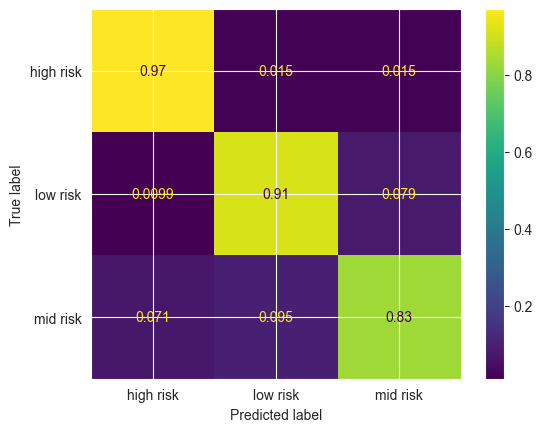

In [25]:
y_hat = pipeline.predict(X_train)

evaluation(y_train, y_hat)

##### Тестовая выборка

f_beta = 0.8116


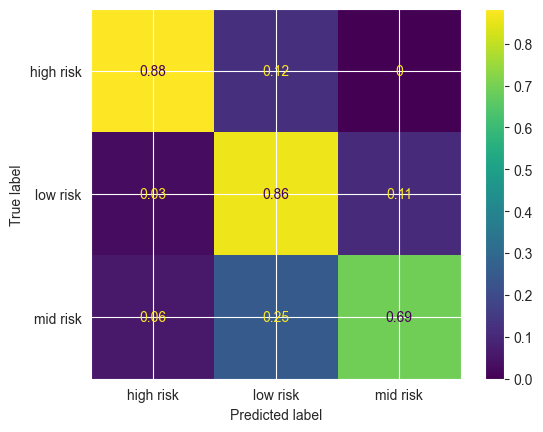

In [26]:
y_hat = pipeline.predict(X_test)

evaluation(y_test, y_hat)

### Вывод

1. Созданы модели: 
    + LogisticRegression, 
    + RandomForestClassifier, 
    + SVC, 
    + AdaBoostingClassifier на основе дерева решений.  
2. Путем применения RandomizedSearchCV выбраны лучшие гиперпараметры для каждой модели.
3. Оценка проводилась на кросс-валидационной выборке
4. Путем стэкинга с финализатором CatBoostClassifier получены предсказания на тренировочной и тестовой выборках.
5. Разница в результатах в выборках свидетельствует о переобучении модели.
6. На тренировочных данных модель хорошо справляется с предсказанием категорий высокого и низкого риска и немного хуже категорию среднего риска.
7. Финальное значение метрики- 0.81.

# Общий вывод

1. Проведено исследование признаков путем: 
    - исследования основной информации о датасете
    - корреляционного анализа
    - попарного сравнения признаков
    - визуализаций
2. Принято допущение об уникальности пациенок.
3. В рамках обработки проведен инжиниринг признаков:
    - созданы признаки на основании медицинских норм 
    - созданы дополнительные признаки
4. Данные подготовлены к обучению, разбиты на подвыборки, разделены по типам.
5. Проведен выбор лучших гиперпараметров выбранных моделей и осуществлено предсказание на тренировочной и тестовой выборках.
6. Результат на тестовой выборке: 0.81
7. Возможно большее количество пациенток и более разнообразные их характеристики, а так же понимание динамики характеристик на разных сроках беременности и состояния здоровья до беременности, смогут улучшить предсказательные способности модели.